In [ ]:
!pip install ultralytics
!pip install pdf2image
!apt-get update
!apt-get install -y locales
!locale-gen en_US.UTF-8
!update-locale LANG=en_US.UTF-8
!export LANG=en_US.UTF-8
!export LC_ALL=en_US.UTF-8
!apt-get install -y poppler-utils
!pip install easyocr PyMuPDF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.9 MB/s eta 0:00:00
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:5 https://cli.github.com/packages stable InRelease
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,246 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages 

In [ ]:
# Подключаем Google Drive
from google.colab import drive
import os
import openai
import time
import base64

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install jiwer
# 🛠 Импорты
import re
import cv2
import pandas as pd
from jiwer import wer
from pdf2image import convert_from_path
from ultralytics import YOLO
from google.colab import files
import yaml
import torch
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 31.9 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# **код чистит предыдущие данные, делает распознавание с помощью Easy OCR и потом конечный результат распознавания с помощью gpt-o4**

In [ ]:
# 🧰 Константы и настройка
DEFAULT_MODEL_PATH = "/content/drive/MyDrive/Дипломный проект/5_этап/best (4).pt"
DEFAULT_HINTS_FOLDER = "/content/drive/MyDrive/Дипломный проект/5_этап/results_easy_ocr"
DEFAULT_TEMP_FOLDER = "/content/temp"

os.makedirs(DEFAULT_TEMP_FOLDER, exist_ok=True)
os.makedirs(DEFAULT_HINTS_FOLDER, exist_ok=True)

client = openai.OpenAI(api_key="sk-...")  # <-- твой ключ
CLASS_NAMES = {0: "table", 1: "text"}

Saving photo_2025-04-26_16-02-06.jpg to photo_2025-04-26_16-02-06.jpg

🔍 Файл: /content/temp/photo_2025-04-26_16-02-06.jpg

image 1/1 /content/temp/photo_2025-04-26_16-02-06.jpg: 480x640 2 tables, 108.0ms
Speed: 16.1ms preprocess, 108.0ms inference, 365.9ms postprocess per image at shape (1, 3, 480, 640)


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.1% Completetable 1


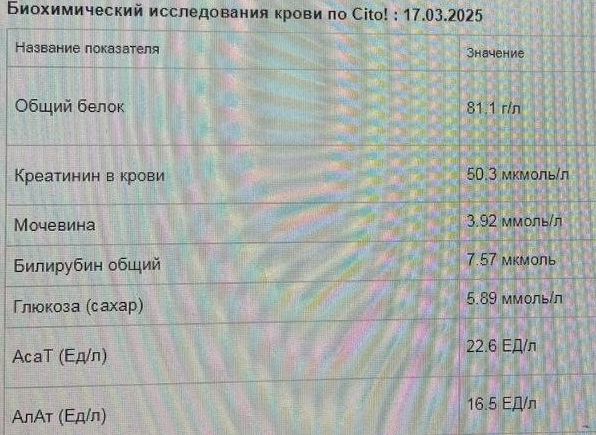

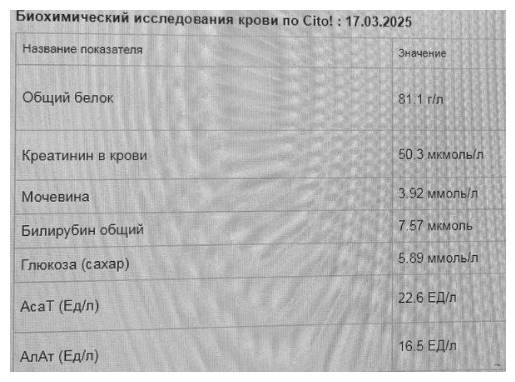

биохимический исследования крови по с1то!
17.03.2025 назбание показателя значение общий белок 81.1 гел креатинин в крови 50.3 мкмоль л мочевина
3.92 ммолыл билирубин общий 7.57 мкмоль 5.89 ммолыл глюкоза (сахар) асат (едол) 22.6 едмл 16.5 едмл
алат (едал) Содержимое переменной valids: биохимический исследования крови по с1то! 17.03.2025 назбание показателя значение общий белок 81.1 гел креатинин в крови 50.3 мкмоль л мочевина 3.92 ммолыл билирубин общий 7.57 мкмоль 5.89 ммолыл глюкоза (сахар) асат (едол) 22.6 едмл 16.5 едмл алат (едал) 


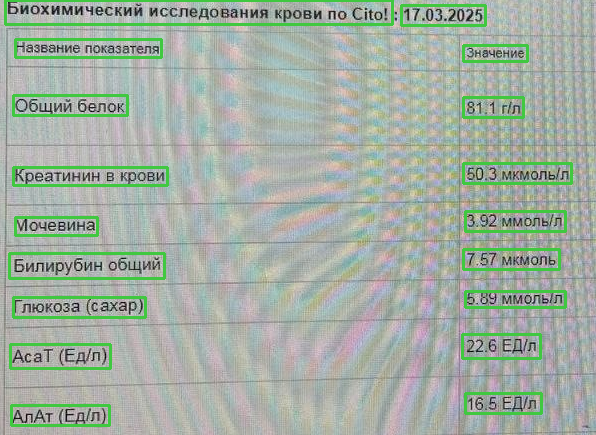

📄 Результат GPT:
Биохимический исследования крови по Cito!: 17.03.2025
Название показателя                        Значение
Общий белок                                    81.1 г/л
Креатинин в крови                           50.3 мкмоль/л
Мочевина                                         3.92 ммоль/л
Билирубин общий                           7.57 мкмоль/л
Глюкоза (сахар)                              5.89 ммоль/л
АсАт (Ед/л)                                     22.6 Ед/л
АлАт (Ед/л)                                     16.5 Ед/л
✅ Сохранено: /content/temp/photo_2025-04-26_16-02-06_output_table_1.txt
📄 Результат GPT:
Биохимический исследования крови по Cito!: 17.03.2025
Название показателя                        Значение
Общий белок                        81 г/л
Креатинин в крови                        503 мкмоль/л
Мочевина                        9.2 ммоль/л
Билирубин общий                        57 мкмоль/л
Глюкоза (сахар)                        5.89 ммоль/л
Асат (Ед/л)                      

In [ ]:
import easyocr
from google.colab.patches import cv2_imshow
import shutil

def clean_old_results(folder="/content/temp"):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            os.remove(file_path)
        except:
            pass

# 📥 Загрузка и конвертация файлов (pdf → jpg)
def load_and_convert_file(file_path, temp_folder=DEFAULT_TEMP_FOLDER):
    if file_path.lower().endswith(".pdf"):
        images = convert_from_path(file_path)
        paths = []
        for i, img in enumerate(images):
            img_path = os.path.join(temp_folder, f"page_{i+1}.jpg")
            img.save(img_path, "JPEG")
            paths.append(img_path)
        return paths
    elif file_path.lower().endswith((".jpg", ".jpeg", ".png")):
        return [file_path]
    else:
        print("❌ Формат не поддерживается")
        return []

# 🔍 Детекция текста или таблиц
def detect_text_or_table(image_paths, model_path=DEFAULT_MODEL_PATH, conf_threshold=0.6):
    model = YOLO(model_path)
    detected = []
    for image_path in image_paths:
        img = cv2.imread(image_path)
        if img is None:
            print(f"❌ Не удалось загрузить: {image_path}")
            continue
        results = model(image_path)
        for result in results:
            for box in result.boxes:
                conf = float(box.conf[0])
                if conf < conf_threshold:
                    continue
                x_min, y_min, x_max, y_max = map(int, box.xyxy[0])
                class_id = int(box.cls[0])
                if class_id in CLASS_NAMES:
                    crop = img[y_min:y_max, x_min:x_max]
                    detected.append((crop, CLASS_NAMES[class_id], image_path))
    return detected

def process_detected_objects(detected_objects):
    results_dir = "/content/drive/MyDrive/Дипломный проект/5_этап/results_easy_ocr"

    reader = easyocr.Reader(['ru'])

    for i, (image, class_type, source_path) in enumerate(detected_objects):
        print(f"{class_type} {i+1}")
        cv2_imshow(image)

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        plt.imshow(gray, cmap='gray')
        plt.axis('off')
        plt.show()

        results = reader.readtext(image)

        valids = []
        base_name = os.path.splitext(os.path.basename(source_path))[0]
        output_txt = os.path.join(results_dir, f"{base_name}_{class_type}_{i+1}.txt")

        with open(output_txt, 'w', encoding='UTF-8') as f:
            for j, result in enumerate(results):
                text = result[1].lower()
                valids.append(text + ' ')
                if j % 8 == 0:
                    print(text)
                    f.write(text + '\n')
                else:
                    print(text, end=' ')
                    f.write(text + ' ')

        print("Содержимое переменной valids:", ''.join(valids))

        img_r = image.copy()
        for result in results:
            lt = tuple(map(int, result[0][0]))
            rb = tuple(map(int, result[0][2]))
            cv2.rectangle(img_r, lt, rb, (64, 200, 64), 2)

        cv2_imshow(img_r)


DEFAULT_HINTS_FOLDER = "/content/drive/MyDrive/Дипломный проект/5_этап/results_easy_ocr"

# 🧬 Преобразование изображения в base64
def encode_image_array(image_array):
    _, buffer = cv2.imencode(".jpg", image_array)
    return base64.b64encode(buffer).decode("utf-8")

# 🧠 Распознавание текста через GPT (сократил, чтобы код влез, вставь свой полный)
def recognize_with_gpt(image_array, hint_text=None):
    try:
        img_base64 = encode_image_array(image_array)

        # 🧩 Синонимы (можно оставить, если нужно)
        synonyms = {
            "Глюкоза (сахар)": {
        "id": 1,
        "синонимы": [
            "Глюкоза", "Глюкоза сывороточная", "Сахар", "Сахар в крови", "Декстроза", "Глюкоза плазмы",
            "глюкоза (сахар)", "глюказа (сахар)", "глюкоза сахар", "глюкоза"
        ]
    },
    "Мочевина": {
        "id": 2,
        "синонимы": [
            "Мочевина", "Азот мочевины", "Остаточный азот крови", "Небелковый азот крови", "Urea", "BUN (Blood Urea Nitrogen)",
            "мочевина"
        ]
    },
    "Креатинин в крови": {
        "id": 3,
        "синонимы": [
            "Креатинин", "Creatinine", "Креатинин сывороточный", "Креатинин в крови", "креатинин крови", "креатинин"
        ]
    },
    "ХС. Общий холестерин в сыворотке крови": {
        "id": 4,
        "синонимы": [
            "Общий холестерин", "Cholesterol", "Холестерин", "Холестерол", "Total Cholesterol",
            "ХС. Общий холестерин в сыворотке крови", "хс общий холестерин в сыворотке крови", "хс общий",
            "хс: общий холестерин в сыворотке", "хс обши", "хс общий холестерин", "хс, общий холестерин сыворотке крови"
        ]
    },
    "Холестерин ЛПНП": {
        "id": 5,
        "синонимы": [
            "Холестерин ЛПНП", "Холестерин-ЛПНП", "Х-ЛПНП", "Х ЛПНП", "ХС ЛПНП", "Липопротеины низкой плотности",
            "Плохой холестерол", "LDL", "Low-Density Lipoprotein",
            "холестерин лпнп", "хопестерин лпнп"
        ]
    },
    "Холестерин ЛПВП": {
        "id": 6,
        "синонимы": [
            "Холестерин ЛПВП", "Холестерин-ЛПВП", "Х-ЛПВП", "Х ЛПВП", "ХС ЛПВП", "Липопротеины высокой плотности",
            "HDL", "High-Density Lipoprotein", "Хороший холестерол",
            "холестерин лпвп", "хопестерин-лпвп"
        ]
    },
    "Ферритин": {
        "id": 33,
        "синонимы": [
            "Ферритин", "Ferritin", "ферритин", "ферритин мкг п", "ферритин мкгел"
        ]
    },
    "Железо (Fe)": {
        "id": 32,
        "синонимы": [
            "Железо", "Сывороточное железо", "Iron", "Fe", "Железо (Fe)", "железо (ге)", "железо"
        ]
    },
    "Билирубин общий": {
        "id": 10,
        "синонимы": [
            "Общий билирубин", "Билирубин", "Total Bilirubin", "TBIL", "Билирубин общий", "билирубин общий"
        ]
    },
    "Билирубин прямой": {
        "id": 11,
        "синонимы": [
            "Прямой билирубин", "Связанный билирубин", "Конъюгированный билирубин", "Direct Bilirubin", "DBIL",
            "Билирубин прямой", "билирубин прямой"
        ]
    },
    "Асат (Ед/л)": {
        "id": 20,
        "синонимы": [
            "Асат (Ед/л)", "АсАт", "AST", "Аспартатаминотрансфераза", "Аспартат-аминотрансфераза", "Aspartate Aminotransferase",
            "асат (ед/л)", "асат (едал)", "асат (едол)", "асаТ (Ед/л)"
        ]
    },
    "Алат (Ед/л)": {
        "id": 21,
        "синонимы": [
            "АлАт", "АЛТ", "ALT", "Аланинаминотрансфераза", "Аланин-аминотрансфераза", "Alanine Aminotransferase",
            "Алат (Ед/л)", "алат (ед/л)", "алат (едал)", "алат (едмл)"
        ]
    },
    "Общий белок": {
        "id": 14,
        "синонимы": [
            "Общий белок", "Total Protein", "TP", "общий белок"
        ]
    },
    "Амилаза": {
        "id": 24,
        "синонимы": [
            "Амилаза", "Альфа-амилаза", "Amylase", "AMY", "амилаза общая", "амилаза"
        ]
    },
    "Триглицериды": {
      "id": 8,
      "синонимы": ["Триглицериды", "Trig", "ТГ", "Triglycerides", "Липиды"]
    },
    "Фосфолипиды": {
      "id": 9,
      "синонимы": ["Фосфолипиды", "Phospholipids"]
    },
    "Билирубин общий": {
      "id": 10,
      "синонимы": ["Общий билирубин", "Билирубин", "Total Bilirubin", "TBIL"]
    },
    "Билирубин прямой": {
      "id": 11,
      "синонимы": ["Прямой билирубин", "Связанный билирубин", "Конъюгированный билирубин", "Direct Bilirubin", "DBIL"]
    },
    "Билирубин непрямой": {
      "id": 12,
      "синонимы": ["Непрямой билирубин", "Свободный билирубин", "Неконъюгированный билирубин", "Indirect Bilirubin", "IBIL"]
    },
    "Дополнительные билирубины": {
      "id": 13,
      "синонимы": ["Билирубин", "Моноглюкоронид", "Диглюкоронид", "Билирубин-глюкуронид"]
    },
    "Общий белок": {
      "id": 14,
      "синонимы": ["Общий белок", "Total Protein", "TP"]
    },
    "Альбумин": {
      "id": 15,
      "синонимы": ["Альбумин", "Albumin", "ALB"]
    },
    "Альфа-1-глобулины": {
      "id": 16,
      "синонимы": ["Альфа-1-глобулины", "Alpha-1-globulins"]
    },
    "Альфа-2-глобулины": {
      "id": 17,
      "синонимы": ["Альфа-2-глобулины", "Alpha-2-globulins"]
    },
    "Бета-глобулины": {
      "id": 18,
      "синонимы": ["Бета-глобулины", "Beta-globulins"]
    },
    "Гамма-глобулины": {
      "id": 19,
      "синонимы": ["Гамма-глобулины", "Gamma-globulins"]
    },
    "АСТ": {
      "id": 20,
      "синонимы": ["АСТ", "АсАт", "AST", "Аспартатаминотрансфераза", "Аспартат-аминотрансфераза", "Aspartate Aminotransferase"]
    },
    "АЛТ": {
      "id": 21,
      "синонимы": ["АлАт", "АЛТ", "ALT", "Аланинаминотрансфераза", "Аланин-аминотрансфераза", "Alanine Aminotransferase"]
    },
    "Щелочная фосфатаза": {
      "id": 22,
      "синонимы": ["Щелочная фосфатаза", "ALP", "Alkaline Phosphatase"]
    },
    "Липаза": {
      "id": 23,
      "синонимы": ["Липаза", "Lipase", "LPS"]
    },
    "Амилаза": {
      "id": 24,
      "синонимы": ["Амилаза", "Альфа-амилаза", "Amylase", "AMY"]
    },
    "Гамма-ГТ": {
      "id": 25,
      "синонимы": ["Гамма-ГТП", "Гамма-глутамилтранспептидаза", "Гамма-глютаминтранспептидаза", "Глютаминтранспептидаза", "ГГТ", "Гамма-ГТ", "GGT", "Гамма-глутамилтрасфераза", "Gamma-Glutamyl Transferase"]
    },
    "ЛДГ": {
      "id": 26,
      "синонимы": ["Лактатдегидрогеназа", "Лактат дегидрогеназа", "ЛДГ", "ЛДГ-1 фракция", "aHBDH", "Lactate Dehydrogenase", "LDH"]
    },
    "Креатинкиназа": {
      "id": 27,
      "синонимы": ["Креатинфосфокиназа", "Креатинкиназа", "КФК", "Креатинкиназа-МБ", "CK", "Creatine Kinase", "CK-MB"]
    },
    "Кальций": {
      "id": 28,
      "синонимы": ["Кальций", "Кальций общий", "Кальций ионизированный", "Calcium", "Ca"]
    },
    "Калий": {
      "id": 29,
      "синонимы": ["Калий", "Potassium", "K"]
    },
    "Натрий": {
      "id": 30,
      "синонимы": ["Натрий", "Sodium", "Na"]
    },
    "Хлор": {
      "id": 31,
      "синонимы": ["Хлор", "Хлориды", "Chloride", "Cl"]
    },
    "Железо": {
      "id": 32,
      "синонимы": ["Железо", "Сывороточное железо", "Iron", "Fe"]
    },
    "Ферритин": {
      "id": 33,
      "синонимы": ["Ферритин", "Ferritin"]
    },
    "Трансферрин": {
      "id": 34,
      "синонимы": ["Трансферрин", "Transferrin"]
    },
    "Витамин D": {
      "id": 35,
      "синонимы": ["Витамин 25(OH) D", "25-OH витамин D", "25-Hydroxyvitamin D", "Витамин D3", "Холекальциферол"]
    },
    "Магний": {
      "id": 36,
      "синонимы": ["Магний", "Magnesium", "Mg"]
    },
    "Фосфор": {
      "id": 37,
      "синонимы": ["Фосфор", "Phosphorus", "P"]
    },
    "Цинк": {
      "id": 38,
      "синонимы": ["Цинк", "Zinc", "Zn"]
    },
    "Селен": {
      "id": 39,
      "синонимы": ["Селен", "Selenium", "Se"]
    },
    "Медь": {
      "id": 40,
      "синонимы": ["Медь", "Copper", "Cu"]
    },
    "Ревматоидный фактор (РФ)": {
      "id": 41,
      "синонимы": ["Ревматоидный фактор", "РФ", "Rheumatoid Factor", "RF"]
    },
    "Кальций ионизированный": {
      "id": 42,
      "синонимы": ["Кальций ионизированный", "Ионизированный кальций","Ca2+", "Ionized Calcium", "Calcium, Ionized"]
    }
   }
        synonyms_text = "\n".join([f"{k}: {', '.join(v['синонимы'])}" for k,v in synonyms.items()])

        messages = [
            {"role": "system", "content": "Ты OCR-помощник. Извлекай название показателя и значение в одной строке."}
        ]
        if hint_text:
            messages.append({"role": "user", "content": f"Вот подсказка из похожего файла:\n{hint_text}"})
        messages.append({"role": "user", "content": f"Для распознавания учитывай синонимы:\n{synonyms_text}"})
        messages.append({
            "role": "user",
            "content": [
                {"type": "text", "text": "Пожалуйста, извлеки информацию с изображения медицинского анализа. "
                                          "Результат должен строго соответствовать следующему формату:\n\n"
                                          "Биохимический исследования крови по Cito!: <дата>\n"
                                          "Название показателя                        Значение\n"
                                          "Ферритин                                            0\n"
                                          "Железо (Fe)                                         0\n"
                                          "...\n\n"
                                          "Название каждого показателя и его значение должны быть **в одной строке**, "
                                          "даже если на изображении они визуально находятся на разных строках. "
                                          "Не используй перенос строки между названием и значением. "
                                          "Не добавляй никаких дополнительных слов, символов или комментариев. "
                                          "Оставь строку где написано: Название показателя   Значение"
                                          "Только извлечённые данные в нужной структуре."},
                {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"}}
            ]
        })

        response = client.chat.completions.create(
            model="gpt-4o", messages=messages, max_tokens=1000
        )
        text = response.choices[0].message.content
        print("📄 Результат GPT:")
        print(text)
        return text
    except Exception as e:
        print(f"❌ Ошибка: {e}")
        return None

# 💾 Сохранение текста в файл
def save_text_to_file(text, save_path):
    with open(save_path, "w", encoding="utf-8") as f:
        f.write(text if text else "[Ошибка распознавания]")
    print(f"✅ Сохранено: {save_path}")

def preprocess_image(image):
    # Если изображение цветное → переводим в серый
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Адаптивная бинаризация
    thresh = cv2.adaptiveThreshold(
        image, 255,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY_INV, 15, 10
    )
    return thresh

# 🧹 Предобработка изображения
#def preprocess_image(image):
    #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #thresh = cv2.adaptiveThreshold(
        #image, 255,
        #cv2.ADAPTIVE_THRESH_MEAN_C,
        #cv2.THRESH_BINARY_INV, 15, 10
    #)
    #return thresh

# 🚀 Основной пайплайн
def run_pipeline(
    test_folder=DEFAULT_TEMP_FOLDER,
    model_path=DEFAULT_MODEL_PATH,
    hints_folder=DEFAULT_HINTS_FOLDER
):
    files_list = [os.path.join(test_folder, f)
                  for f in os.listdir(test_folder)
                  if f.lower().endswith(('.jpg', '.jpeg', '.png', '.pdf'))]

    for file_path in files_list:
        print(f"\n🔍 Файл: {file_path}")
        image_paths = load_and_convert_file(file_path)
        detected = detect_text_or_table(image_paths, model_path)
        if detected:
                easy_ocr = process_detected_objects(detected)
        else:
              print(f"⚠️ Ничего не найдено на изображении {file_path}")

        base_name = os.path.splitext(os.path.basename(file_path))[0]
        hint_path = os.path.join(hints_folder, f"{base_name}.txt")
        hint_text = None
        if os.path.exists(hint_path):
            with open(hint_path, "r", encoding="utf-8") as f:
                hint_text = f.read()

        for idx, (crop, class_type, _) in enumerate(detected):
            # 🧠 Распознавание без предобработки
            text_no_pre = recognize_with_gpt(crop, hint_text)
            filename_no_pre = f"{base_name}_output_{class_type}_{idx+1}.txt"
            save_text_to_file(text_no_pre, os.path.join(test_folder, filename_no_pre))

            # 🧹 Предобработка и повторное распознавание
            crop_pre = preprocess_image(crop)
            text_pre = recognize_with_gpt(crop_pre, hint_text)
            filename_pre = f"{base_name}_output_{class_type}_{idx+1}_preprocessed.txt"
            save_text_to_file(text_pre, os.path.join(test_folder, filename_pre))

    print("\n✅ Обработка завершена! Вы получили два результата для каждого файла: с предобработкой и без.")

DEFAULT_TEMP_FOLDER = "/content/temp"
os.makedirs(DEFAULT_TEMP_FOLDER, exist_ok=True)

# чистим папку перед загрузкой
clean_old_results(DEFAULT_TEMP_FOLDER)

# загружаем файл
uploaded = files.upload()
test_file = list(uploaded.keys())[0]

# перемещаем файл в temp
shutil.move(test_file, os.path.join(DEFAULT_TEMP_FOLDER, test_file))

# запускаем пайплайн
run_pipeline(test_folder=DEFAULT_TEMP_FOLDER)
